In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()
from copy import deepcopy
import catboost as cgb
import imp
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import r2_score , mean_squared_error
import lightgbm
from scipy.interpolate import interp1d
url="C:/Users/louis/Downloads/Projet/"

In [2]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [4]:
def _haversine_distance(lat_A, lon_A, lat_B, lon_B):
    earth_radius = 6373
    distance = np.sin((lat_B - lat_A) / 2) ** 2 + np.cos(lat_A) * \
               np.cos(lat_B) * np.sin((lon_B - lon_A) / 2) ** 2
    distance = 2 * earth_radius * np.arcsin(distance)
    return distance



problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()
X_encoded = X_df

url="C:/Users/louis/Downloads/Projet/"
final = pd.read_csv(url+"Ajout_données.csv")
final["Date"]=pd.to_datetime(final["Date"])

X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date -pd.to_datetime("1970-01-01")).days)
X_df_Depart = X_encoded.drop("Arrival", axis=1)
X_df_Arrivee = X_encoded.drop("Departure", axis=1)


fusion_depart = X_df_Depart.merge(final.add_suffix('_depart'),how="left", \
left_on=["DateOfDeparture","Departure"],right_on=["Date_depart","AirPort_depart"])
fusion_arrivee = X_df_Arrivee.merge(final.add_suffix('_arrivee'),how="left",\
left_on=["DateOfDeparture","Arrival"],right_on=["Date_arrivee","AirPort_arrivee"])
fusion_arrivee=fusion_arrivee.drop(["DateOfDeparture","WeeksToDeparture",\
                                                          "std_wtd","year","month","day","weekday","week","n_days"],axis=1)
perfect = fusion_depart.merge(fusion_arrivee, left_index=True, right_index=True)

perfect["Precipitationmm_arrivee"]=np.where(perfect["Precipitationmm_arrivee"] == 'T',0,perfect["Precipitationmm_arrivee"])
perfect["Events_arrivee"]=perfect["Events_arrivee"].fillna("Sunny")
perfect["Precipitationmm_depart"]=np.where(perfect["Precipitationmm_depart"] == 'T',0,perfect["Precipitationmm_depart"])
perfect["Events_depart"]=perfect["Events_depart"].fillna("Sunny")
perfect = perfect.join(pd.get_dummies(perfect['Events_depart'], prefix='d'))
perfect = perfect.join(pd.get_dummies(perfect['Events_arrivee'], prefix='a'))
perfect = perfect.drop('Events_depart', axis=1)
perfect = perfect.drop('Events_arrivee', axis=1)
liste_flo = ["lat_arrivee","lon_arrivee","Precipitationmm_arrivee","lat_depart","lon_depart","Precipitationmm_depart"]
perfect[liste_flo]=perfect[liste_flo].astype(float)
perfect['distance'] = _haversine_distance(\
              perfect['lat_arrivee'].values,\
              perfect['lon_arrivee'].values,\
              perfect['lat_depart'].values,\
              perfect['lon_depart'].values)
del perfect["DateOfDeparture"]
perfect=perfect.drop(["DateOfDeparture_arrivee","Date_depart",\
          "DateOfDeparture_depart","Date_arrivee","City_arrivee",\
          "State_arrivee","City_depart","State_depart","AirPort_arrivee",\
          "AirPort_depart","is_weekend_depart","is_holiday_depart",\
          "is_close_from_weekend_or_holiday_depart"],axis=1)
perfect = perfect.rename(columns={'is_weekend_arrivee': 'is_weekend',\
          'is_holiday_arrivee':'is_holiday',\
          'is_close_from_weekend_or_holiday_arrivee':'is_close_from_weekend_or_holiday'})
#perfect=perfect.drop([c for c, d in zip (perfect.columns,perfect.dtypes) if d==np.object],axis=1)
perfect = perfect.join(pd.get_dummies(perfect['Departure'], prefix='d'))
perfect = perfect.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
perfect = perfect.drop('Departure', axis=1)
perfect = perfect.drop('Arrival', axis=1)
del perfect["a_Sunny"]
for i in [c for c, d in zip (perfect.columns,perfect.dtypes) if d==np.bool] :
            perfect[i]=np.where(perfect[i] == False,0,1)   

hide_toggle()

### Light GBM non tuné

In [58]:
from sklearn.model_selection import train_test_split
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

train_data = lightgbm.Dataset(X_train, label=y_train, categorical_feature=cat_algo)
val_data = lightgbm.Dataset(X_val, label=y_val, categorical_feature=cat_algo)
test_data = lightgbm.Dataset(X_test, label=y_test)

In [59]:
parameters = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_threads" : 20,
        "learning_rate" : 0.03
}
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=500,
                       early_stopping_rounds=100)

C:\Users\louis\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's rmse: 1.00472
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.99036
[3]	valid_0's rmse: 0.976839
[4]	valid_0's rmse: 0.963767
[5]	valid_0's rmse: 0.951231
[6]	valid_0's rmse: 0.938783
[7]	valid_0's rmse: 0.926853
[8]	valid_0's rmse: 0.915687
[9]	valid_0's rmse: 0.905056
[10]	valid_0's rmse: 0.894402
[11]	valid_0's rmse: 0.883983
[12]	valid_0's rmse: 0.874523
[13]	valid_0's rmse: 0.865352
[14]	valid_0's rmse: 0.855917
[15]	valid_0's rmse: 0.847321
[16]	valid_0's rmse: 0.838937
[17]	valid_0's rmse: 0.830548
[18]	valid_0's rmse: 0.82297
[19]	valid_0's rmse: 0.814901
[20]	valid_0's rmse: 0.806365
[21]	valid_0's rmse: 0.799251
[22]	valid_0's rmse: 0.791214
[23]	valid_0's rmse: 0.784038
[24]	valid_0's rmse: 0.777063
[25]	valid_0's rmse: 0.770248
[26]	valid_0's rmse: 0.763976
[27]	valid_0's rmse: 0.757336
[28]	valid_0's rmse: 0.75086
[29]	valid_0's rmse: 0.745089
[30]	valid_0's rmse: 0.739184
[31]	valid_0's rmse: 0.733476
[32]	valid_0's rmse: 

[313]	valid_0's rmse: 0.423897
[314]	valid_0's rmse: 0.423771
[315]	valid_0's rmse: 0.423593
[316]	valid_0's rmse: 0.423406
[317]	valid_0's rmse: 0.423267
[318]	valid_0's rmse: 0.423088
[319]	valid_0's rmse: 0.423003
[320]	valid_0's rmse: 0.422788
[321]	valid_0's rmse: 0.422541
[322]	valid_0's rmse: 0.422264
[323]	valid_0's rmse: 0.422194
[324]	valid_0's rmse: 0.42215
[325]	valid_0's rmse: 0.422043
[326]	valid_0's rmse: 0.422022
[327]	valid_0's rmse: 0.42195
[328]	valid_0's rmse: 0.421747
[329]	valid_0's rmse: 0.421673
[330]	valid_0's rmse: 0.421543
[331]	valid_0's rmse: 0.421562
[332]	valid_0's rmse: 0.421474
[333]	valid_0's rmse: 0.421394
[334]	valid_0's rmse: 0.421164
[335]	valid_0's rmse: 0.421107
[336]	valid_0's rmse: 0.420992
[337]	valid_0's rmse: 0.421001
[338]	valid_0's rmse: 0.420894
[339]	valid_0's rmse: 0.420699
[340]	valid_0's rmse: 0.420727
[341]	valid_0's rmse: 0.420524
[342]	valid_0's rmse: 0.420422
[343]	valid_0's rmse: 0.420321
[344]	valid_0's rmse: 0.420243
[345]	vali

In [60]:
preds = model.predict(X_test)
mse = mean_squared_error(y_test,preds)
rmse = np.sqrt(mse)
print(rmse)

0.3764356257171233


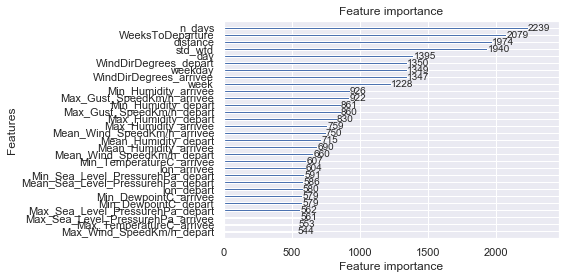

In [12]:
lightgbm.plot_importance(model, max_num_features=30, importance_type='split')

### Optimisation Bayésienne du LightGBM 

In [26]:
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
def lgb_eval(num_leaves,max_depth,reg_alpha,reg_lambda,min_child_samples,subsample_freq,bagging_seed):
    params = {
        "boosting_type": 'gbdt',
        "metric" : "rmse", 
        'objective':'regression',
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "reg_alpha" : reg_alpha,
        "reg_lambda" : reg_lambda,
        #"num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        #'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 0.03,
        "subsample_freq" : int(subsample_freq),
        "bagging_seed" : int(bagging_seed)
        }
    lgtrain = lightgbm.Dataset(X_train, y_train )
    cv_result = lightgbm.cv(params,
                       lgtrain,
                       num_boost_round=500,
                       early_stopping_rounds=100,
                       stratified=False,
                       nfold=8)
    return (-1.0 * np.array(cv_result['rmse-mean'])).max()

In [28]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5, 300),
                                                'max_depth': (4, 12),
                                                'reg_alpha': (0,100),
                                                'min_child_samples': (1, 500),
                                                'bagging_seed' : (0,60),
                                                'subsample_freq' : (0,20),
                                                'reg_lambda':(0,100)
                                                })

lgbBO.maximize(init_points=20 ,n_iter=130)

|   iter    |  target   | baggin... | max_depth | min_ch... | num_le... | reg_alpha | reg_la... | subsam... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.6083   |  13.36    |  11.77    |  45.07    |  111.3    |  97.48    |  0.2464   |  9.481    |
|  2        | -0.4493   |  53.01    |  10.13    |  210.1    |  279.2    |  2.275    |  35.65    |  16.51    |
|  3        | -0.6366   |  34.55    |  11.24    |  494.5    |  237.0    |  74.85    |  97.76    |  10.97    |
|  4        | -0.6371   |  4.661    |  8.758    |  393.2    |  13.21    |  84.7     |  64.82    |  15.7     |
|  5        | -0.5198   |  1.058    |  7.29     |  257.9    |  295.9    |  33.9     |  37.11    |  18.49    |
|  6        | -0.5828   |  50.17    |  9.816    |  388.9    |  59.44    |  55.95    |  1.744    |  1.935    |
|  7        | -0.608    |  3.624    |  6.078    |  217.6    |  238.0    |  84.49    |  77.44    |  7.514    |
|  8      

|  45       | -0.4475   |  42.31    |  10.31    |  192.4    |  71.66    |  0.1873   |  90.22    |  5.561    |
|  46       | -0.3953   |  13.88    |  11.61    |  37.95    |  243.9    |  0.4401   |  0.8403   |  13.71    |
|  47       | -0.5296   |  56.1     |  10.06    |  412.6    |  292.5    |  3.279    |  96.07    |  13.12    |
|  48       | -0.4022   |  8.608    |  9.077    |  18.74    |  25.45    |  0.4787   |  8.91     |  19.9     |
|  49       | -0.4008   |  13.83    |  8.94     |  3.823    |  28.48    |  4.956    |  1.377    |  2.759    |
|  50       | -0.4341   |  3.169    |  11.0     |  151.3    |  269.2    |  0.4232   |  67.44    |  19.08    |
|  51       | -0.4792   |  14.36    |  4.334    |  28.26    |  36.08    |  9.145    |  11.63    |  4.803    |
|  52       | -0.6544   |  60.0     |  12.0     |  1.0      |  5.0      |  100.0    |  100.0    |  0.0      |
|  53       | -0.5644   |  0.0      |  12.0     |  247.8    |  5.0      |  0.0      |  0.0      |  0.0      |
|  54     

|  91       | -0.5655   |  1.752    |  5.424    |  93.76    |  12.22    |  68.05    |  60.05    |  4.402    |
|  92       | -0.427    |  60.0     |  12.0     |  1.0      |  240.0    |  0.0      |  100.0    |  10.78    |
|  93       | -0.5495   |  0.0      |  4.0      |  334.2    |  300.0    |  0.0      |  100.0    |  20.0     |
|  94       | -0.5644   |  12.87    |  11.44    |  1.718    |  15.39    |  70.74    |  25.71    |  19.32    |
|  95       | -0.423    |  0.8704   |  10.37    |  124.3    |  55.43    |  1.716    |  31.08    |  10.09    |
|  96       | -0.5101   |  60.0     |  12.0     |  391.3    |  203.0    |  0.0      |  0.0      |  20.0     |
|  97       | -0.62     |  0.0      |  12.0     |  160.1    |  300.0    |  100.0    |  100.0    |  4.512    |
|  98       | -0.6734   |  0.0      |  12.0     |  500.0    |  106.4    |  100.0    |  100.0    |  0.0      |
|  99       | -0.5657   |  0.0      |  4.0      |  418.0    |  183.0    |  0.0      |  100.0    |  0.0      |
|  100    

|  137      | -0.5525   |  0.0      |  12.0     |  500.0    |  189.6    |  0.0      |  100.0    |  20.0     |
|  138      | -0.659    |  0.0      |  12.0     |  384.3    |  171.7    |  100.0    |  100.0    |  20.0     |
|  139      | -0.4471   |  51.23    |  11.03    |  74.29    |  264.9    |  15.11    |  99.08    |  9.839    |
|  140      | -0.5035   |  56.18    |  11.22    |  251.9    |  36.32    |  26.91    |  50.43    |  11.49    |
|  141      | -0.5317   |  11.54    |  12.0     |  428.0    |  79.41    |  0.0      |  100.0    |  20.0     |
|  142      | -0.5156   |  3.226    |  11.93    |  41.36    |  40.12    |  49.61    |  60.78    |  0.4202   |
|  143      | -0.445    |  57.86    |  7.133    |  153.7    |  104.3    |  0.4338   |  29.17    |  7.765    |
|  144      | -0.4272   |  40.08    |  9.377    |  142.1    |  170.6    |  0.6295   |  1.62     |  14.34    |
|  145      | -0.66     |  0.0      |  12.0     |  416.6    |  121.9    |  100.0    |  0.0      |  0.0      |
|  146    

In [29]:
best_lgb_param=lgbBO.max
print(best_lgb_param)

{'target': -0.3898944516149563, 'params': {'bagging_seed': 9.592851584623201, 'max_depth': 10.122614085120507, 'min_child_samples': 18.19710888090028, 'num_leaves': 75.06480429548625, 'reg_alpha': 1.5256272637739432, 'reg_lambda': 1.1488483334440858, 'subsample_freq': 10.090986858644326}}


#### LightGBM tuné

In [43]:
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

train_data = lightgbm.Dataset(X_train, label=y_train, categorical_feature=cat_algo)
val_data = lightgbm.Dataset(X_val, label=y_val, categorical_feature=cat_algo)
test_data = lightgbm.Dataset(X_test, label=y_test)

In [44]:
parameters = {
        "objective" : "regression",
        "metric" : "rmse", 
        "learning_rate" : 0.03,
        "num_leaves" : int(best_lgb_param['params']['num_leaves']),
        "max_depth" : int(best_lgb_param['params']['max_depth']),
        "reg_alpha" : best_lgb_param['params']['reg_alpha'],
        "num_threads" : 20,
        "min_child_samples" : int(best_lgb_param['params']['min_child_samples']),
        'bagging_seed': int(best_lgb_param['params']['bagging_seed']),
        "subsample_freq" : int(best_lgb_param['params']['subsample_freq']),
        'reg_lambda': int(best_lgb_param['params']['reg_lambda'])
}
        

In [45]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=10000,
                       early_stopping_rounds=100)

C:\Users\louis\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's rmse: 1.00224
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.985531
[3]	valid_0's rmse: 0.969371
[4]	valid_0's rmse: 0.953852
[5]	valid_0's rmse: 0.938968
[6]	valid_0's rmse: 0.92467
[7]	valid_0's rmse: 0.910752
[8]	valid_0's rmse: 0.897623
[9]	valid_0's rmse: 0.885018
[10]	valid_0's rmse: 0.872839
[11]	valid_0's rmse: 0.860877
[12]	valid_0's rmse: 0.849514
[13]	valid_0's rmse: 0.838394
[14]	valid_0's rmse: 0.827555
[15]	valid_0's rmse: 0.817485
[16]	valid_0's rmse: 0.807493
[17]	valid_0's rmse: 0.79815
[18]	valid_0's rmse: 0.789172
[19]	valid_0's rmse: 0.780694
[20]	valid_0's rmse: 0.77257
[21]	valid_0's rmse: 0.764782
[22]	valid_0's rmse: 0.757345
[23]	valid_0's rmse: 0.750403
[24]	valid_0's rmse: 0.743298
[25]	valid_0's rmse: 0.736005
[26]	valid_0's rmse: 0.728182
[27]	valid_0's rmse: 0.720864
[28]	valid_0's rmse: 0.714807
[29]	valid_0's rmse: 0.708183
[30]	valid_0's rmse: 0.701415
[31]	valid_0's rmse: 0.694841
[32]	valid_0's rmse: 

[276]	valid_0's rmse: 0.421796
[277]	valid_0's rmse: 0.421609
[278]	valid_0's rmse: 0.421421
[279]	valid_0's rmse: 0.421358
[280]	valid_0's rmse: 0.421266
[281]	valid_0's rmse: 0.42104
[282]	valid_0's rmse: 0.420891
[283]	valid_0's rmse: 0.420779
[284]	valid_0's rmse: 0.420622
[285]	valid_0's rmse: 0.420559
[286]	valid_0's rmse: 0.420352
[287]	valid_0's rmse: 0.420205
[288]	valid_0's rmse: 0.420093
[289]	valid_0's rmse: 0.419956
[290]	valid_0's rmse: 0.419807
[291]	valid_0's rmse: 0.419622
[292]	valid_0's rmse: 0.419514
[293]	valid_0's rmse: 0.419407
[294]	valid_0's rmse: 0.419271
[295]	valid_0's rmse: 0.419183
[296]	valid_0's rmse: 0.419079
[297]	valid_0's rmse: 0.418915
[298]	valid_0's rmse: 0.418818
[299]	valid_0's rmse: 0.418675
[300]	valid_0's rmse: 0.418645
[301]	valid_0's rmse: 0.418572
[302]	valid_0's rmse: 0.418438
[303]	valid_0's rmse: 0.418214
[304]	valid_0's rmse: 0.41817
[305]	valid_0's rmse: 0.418011
[306]	valid_0's rmse: 0.418014
[307]	valid_0's rmse: 0.417989
[308]	vali

[543]	valid_0's rmse: 0.407908
[544]	valid_0's rmse: 0.407905
[545]	valid_0's rmse: 0.407885
[546]	valid_0's rmse: 0.407886
[547]	valid_0's rmse: 0.407853
[548]	valid_0's rmse: 0.407766
[549]	valid_0's rmse: 0.407755
[550]	valid_0's rmse: 0.407692
[551]	valid_0's rmse: 0.407671
[552]	valid_0's rmse: 0.407662
[553]	valid_0's rmse: 0.407618
[554]	valid_0's rmse: 0.407559
[555]	valid_0's rmse: 0.407552
[556]	valid_0's rmse: 0.407538
[557]	valid_0's rmse: 0.407546
[558]	valid_0's rmse: 0.407516
[559]	valid_0's rmse: 0.407502
[560]	valid_0's rmse: 0.407479
[561]	valid_0's rmse: 0.407503
[562]	valid_0's rmse: 0.407475
[563]	valid_0's rmse: 0.407467
[564]	valid_0's rmse: 0.407469
[565]	valid_0's rmse: 0.407438
[566]	valid_0's rmse: 0.407432
[567]	valid_0's rmse: 0.407424
[568]	valid_0's rmse: 0.407429
[569]	valid_0's rmse: 0.407443
[570]	valid_0's rmse: 0.407413
[571]	valid_0's rmse: 0.407395
[572]	valid_0's rmse: 0.407377
[573]	valid_0's rmse: 0.407352
[574]	valid_0's rmse: 0.407367
[575]	va

[827]	valid_0's rmse: 0.405241
[828]	valid_0's rmse: 0.405237
[829]	valid_0's rmse: 0.40523
[830]	valid_0's rmse: 0.405236
[831]	valid_0's rmse: 0.405228
[832]	valid_0's rmse: 0.405232
[833]	valid_0's rmse: 0.405229
[834]	valid_0's rmse: 0.405227
[835]	valid_0's rmse: 0.405206
[836]	valid_0's rmse: 0.405196
[837]	valid_0's rmse: 0.405194
[838]	valid_0's rmse: 0.405177
[839]	valid_0's rmse: 0.405169
[840]	valid_0's rmse: 0.405166
[841]	valid_0's rmse: 0.405156
[842]	valid_0's rmse: 0.405157
[843]	valid_0's rmse: 0.405165
[844]	valid_0's rmse: 0.405176
[845]	valid_0's rmse: 0.405163
[846]	valid_0's rmse: 0.405149
[847]	valid_0's rmse: 0.405144
[848]	valid_0's rmse: 0.40514
[849]	valid_0's rmse: 0.405146
[850]	valid_0's rmse: 0.405135
[851]	valid_0's rmse: 0.40512
[852]	valid_0's rmse: 0.405135
[853]	valid_0's rmse: 0.405119
[854]	valid_0's rmse: 0.405108
[855]	valid_0's rmse: 0.405114
[856]	valid_0's rmse: 0.405125
[857]	valid_0's rmse: 0.405132
[858]	valid_0's rmse: 0.405121
[859]	valid

[1100]	valid_0's rmse: 0.404671
[1101]	valid_0's rmse: 0.404672
[1102]	valid_0's rmse: 0.404672
[1103]	valid_0's rmse: 0.404666
[1104]	valid_0's rmse: 0.40466
[1105]	valid_0's rmse: 0.404651
[1106]	valid_0's rmse: 0.404647
[1107]	valid_0's rmse: 0.404648
[1108]	valid_0's rmse: 0.404648
[1109]	valid_0's rmse: 0.404648
[1110]	valid_0's rmse: 0.404648
[1111]	valid_0's rmse: 0.404648
[1112]	valid_0's rmse: 0.404648
[1113]	valid_0's rmse: 0.404648
[1114]	valid_0's rmse: 0.404648
[1115]	valid_0's rmse: 0.404648
[1116]	valid_0's rmse: 0.404648
[1117]	valid_0's rmse: 0.404648
[1118]	valid_0's rmse: 0.404648
[1119]	valid_0's rmse: 0.404648
[1120]	valid_0's rmse: 0.404648
[1121]	valid_0's rmse: 0.404648
[1122]	valid_0's rmse: 0.404648
[1123]	valid_0's rmse: 0.404648
[1124]	valid_0's rmse: 0.404648
[1125]	valid_0's rmse: 0.404648
[1126]	valid_0's rmse: 0.404648
[1127]	valid_0's rmse: 0.404648
[1128]	valid_0's rmse: 0.404648
[1129]	valid_0's rmse: 0.404648
[1130]	valid_0's rmse: 0.404648
[1131]	va

In [46]:
preds = model.predict(X_test)
mse = mean_squared_error(y_test,preds)
rmse = np.sqrt(mse)
print(rmse)

0.37014669478466844


Nous n'obtenons pas ici une RMSE nettement plus faible mais le modèle sera plus robuste sur le vrai jeu d'entraînement qui nous sera mis à disposition (8k observations actuellement à 800k à venir)